# Title:    Transaction Categorization

## Business Understanding:-

### Introduction:

Transaction categorization is the ability to recognize the purpose of a transaction based on its description. For long, this process was done manually but now technology can do it efficiently. 

This project will focus on Natural Language Processing using the power of Machine Learning to predict which category a transaction will fall into, given the description of the transaction.

It is no surprise that financial companies need to help their customers organize their finances. Customers want to know what they spend their money on to keep balances in check. 

By categorizing transactions and building better customer engagement tools, Banks can help customers identify frequent purchases and subscriptions, sort income and activity liability with higher accuracy, and reduce credit risks. 


### Business Problem:

This project will focus on Natural Language Processing using the power of Machine Learning to predict which category a transaction will fall into, given the description of the transaction. 

Goal - Build a model to predict transaction categories using the 10 (ten) distinct categories that a transaction may fall into. The categories are as follows:

 1.	Communication Services 
 2.	Education 
 3.	Entertainment
 4.	Finance 
 5.	Health and Community Service 
 6.	Property and Business Services 
 7.	Retail Trade 
 8.	Services to Transport 
 9.	Trade, Professional and Personal Services
 10.	Travel



#### Techniques:

The model would be built using NLP and Classification Machine Learnings.


### Data Definitions:

The dataset provided on the Challenge page is synthetic. This dataset has been scrubbed to replace all transaction numbers with 1's.

Training Dataset – The Training Dataset contains 40,000 unique transactions and their corresponding transaction categories. This data set is used to train the model.

Test Dataset – The Test Dataset contains 10,000 unique transactions with the transaction categories omitted. This dataset will be used to test the solution and identify the correct transaction categories.

The fields in the training data set and testing dataset are same except category which is not present in testing data set. The details description of each field is given in table below –


     
Field:

* CDF_SEQ_ID	Unique number to identify Wells Fargo transaction. This has been prepended with a 'T' to prevent accidental formatting as a number by Excel.
* SOR	Source of record (HH = ACH, HY = Bill Pay, CC = Credit Card)
* trans_desc	Description of the transaction
* merchant_cat_code	ISO18245 merchant category code
* amt	transaction amount
* db_cr_cd	flag for credit c, or debit d
* payment_reporting_category	Type of payment (Wire transfer, bill pay, etc.)
* is_international	International transaction flag
* default_brand	Merchant Name
* default_location	merchant location
* qrated brand	Sanitized merchant name
* coalesced_brand	Sanitized brand where it exists; default brand otherwise
* cateogy	transaction type


## Data Understanding:

In [97]:
# import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import missingno as msno
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# read the dataset and shoaw shape and head


train_trans = pd.read_excel("data/Training_Data.xlsx")

test_trans = pd.read_excel("data/Test_Data.xlsx")


print(f"Training Data Head")

train_trans.shape
train_trans.head()

print(f"\nTesting Data Head\n")

test_trans.shape
test_trans.head()

Training Data Head


(40000, 14)

,sor,cdf_seq_no,trans_desc,merchant_cat_code,amt,db_cr_cd,payment_reporting_category,payment_category,is_international,default_brand,default_location,qrated_brand,coalesced_brand,Category
0,HH,T20110701260061756,RECUR DEBIT CRD PMT11/11 DELTA DENTAL OF A11 O...,6300.0,58.34,D,Card,Debit Card,False,DELTA DENTAL OF A11 OF,111-1111111 AR,Delta Dental,Delta Dental,Finance
1,HH,T201302289909010349,"CHECK CRD PURCHASE 11/11 SURETY SOLUTIONS, ...",NaN,103.00,D,Card,Check Card,False,"SURETY SOLUTIONS,",111-111-1111 OR,Surety Solutions,Surety Solutions,Finance
2,HH,T20130726991361190114550,CHECK CRD PURCHASE 11/11 THE COPY STOP ...,NaN,22.44,D,Card,Check Card,False,THE COPY STOP,SALT LAKE CIT UT,The Copy Stop,The Copy Stop,Finance
3,BK,T201207095780929968,MARKET ALERT INC 111-111-1111 TX,7375.0,22.44,NaN,Card,Credit Card,False,MARKET ALERT INC,111-111-1111 TX,Market Alert,Market Alert,Finance
4,HH,T20131230990558080004939,CHECK CRD PURCHASE 11/11 PERT- NER PERFECT ...,NaN,66.25,D,Card,Check Card,False,PERT- NER PERFECT,THE WOODLANDS TX,Hometown Insurance Partners,Hometown Insurance Partners,Finance



Testing Data Head



(10000, 14)

,sor,cdf_seq_no,trans_desc,merchant_cat_code,amt,db_cr_cd,payment_reporting_category,payment_category,is_international,default_brand,default_location,qrated_brand,coalesced_brand,Category
0,HH,T20131230990668080055738,CHECK CRD PURCHASE 11/11 PACKAGE EXPRESS ...,NaN,10.35,D,Card,Check Card,False,PACKAGE EXPRESS,LACEY WA,Package Express,Package Express,NaN
1,HH,T201302289918775816,RECUR DEBIT CRD PMT11/11 YP *FRMLY AT&T AD ...,NaN,36.00,D,Card,Debit Card,False,YP *FRMLY AT&T AD,111-111-1111 CA,At And T,At And T,NaN
2,HH,T20130726991361190218055,CHECK CRD PURCHASE 11/11 NORMAN G JENSEN IN ...,NaN,27.00,D,Card,Check Card,False,NORMAN G JENSEN IN,111-1111111 MN,Norman G Jensen,Norman G Jensen,NaN
3,HH,T201208319924922772,CHECK CRD PUR RTRN 11/11 TWILIO ...,NaN,20.00,C,Card,Check Card,False,TWILIO,SAN FARANSICO CA,Twilio,Twilio,NaN
4,HH,T20131230990638080027066,CHECK CRD PURCHASE 11/11 AT&T D11K 1111 ...,NaN,325.78,D,Card,Check Card,False,AT&T D11K 1111,FORT WORTH TX,At And T,At And T,NaN


## Exploratory Data Analysis:

In [3]:
# show info of the train dataset

train_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sor                         40000 non-null  object 
 1   cdf_seq_no                  40000 non-null  object 
 2   trans_desc                  40000 non-null  object 
 3   merchant_cat_code           24691 non-null  float64
 4   amt                         40000 non-null  float64
 5   db_cr_cd                    39688 non-null  object 
 6   payment_reporting_category  40000 non-null  object 
 7   payment_category            40000 non-null  object 
 8   is_international            40000 non-null  bool   
 9   default_brand               40000 non-null  object 
 10  default_location            39994 non-null  object 
 11  qrated_brand                36673 non-null  object 
 12  coalesced_brand             40000 non-null  object 
 13  Category                    400

In [4]:
# display the descriptive stats

train_trans.describe(include=['O'])
train_trans.describe()

,sor,cdf_seq_no,trans_desc,db_cr_cd,payment_reporting_category,payment_category,default_brand,default_location,qrated_brand,coalesced_brand,Category
count,40000,40000,40000,39688,40000,40000,40000,39994,36673,40000,40000
unique,2,40000,40000,2,1,5,39791,8201,33763,37050,10
top,HH,T20110701260061756,RECUR DEBIT CRD PMT11/11 DELTA DENTAL OF A11 O...,D,Card,Check Card,LIVINGSOCIAL*,111-111-1111 CA,Bp,Bp,Retail Trade
freq,39688,1,1,37962,40000,36986,3,860,78,78,13500


,merchant_cat_code,amt
count,24691.000000,40000.000000
mean,6263.878134,75.870519
std,1217.403683,254.587351
min,0.000000,0.010000
25%,5699.000000,14.007500
50%,5814.000000,29.990000
75%,7230.000000,63.650000
max,9405.000000,23313.800000


<AxesSubplot:>

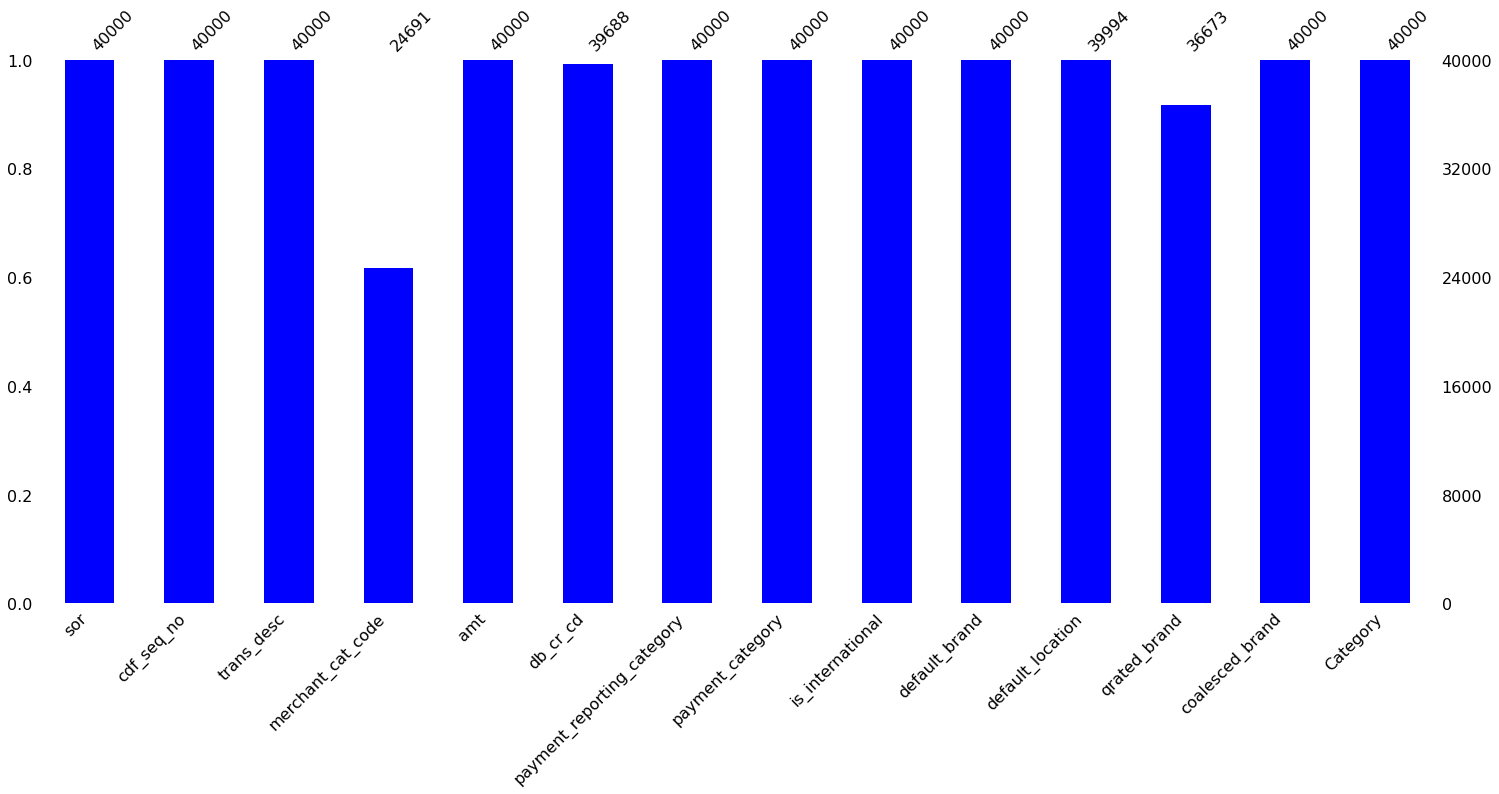

In [5]:
#  display missing values

msno.bar(train_trans, color='b')

### Insights:

Based on above, we see that there are few fields with null or missing values, Transaction description feature has all unique values and no missing data, all transactions have categories assigned. We are not going to handle missing values since required features have all the values.

In [6]:
# display number of transactions per category

train_trans['Category'].value_counts()

Retail Trade                                 13500
Entertainment                                11255
Trade, Professional and Personal Services     5275
Health and Community Services                 4157
Services to Transport                         2317
Travel                                        1489
Property and Business Services                1095
Education                                      445
Communication Services                         282
Finance                                        185
Name: Category, dtype: int64

In [7]:
#  create column to show number of words per transaction

train_trans['trx_len'] = train_trans['trans_desc'].apply(lambda x: len(x))

Retail Trade                                 33.7500
Entertainment                                28.1375
Trade, Professional and Personal Services    13.1875
Health and Community Services                10.3925
Services to Transport                         5.7925
Travel                                        3.7225
Property and Business Services                2.7375
Education                                     1.1125
Communication Services                        0.7050
Finance                                       0.4625
Name: Category, dtype: float64


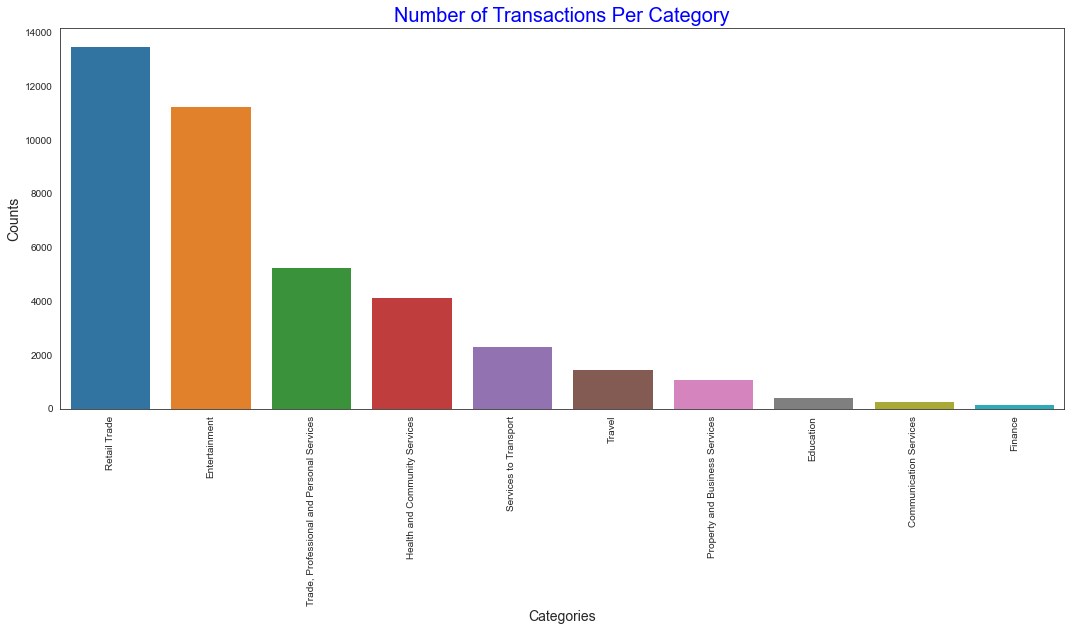

In [8]:
# plot bar chart for number of transactions per category

print(train_trans['Category'].value_counts(normalize=True)*100)

sns.set_style('white')
plt.figure(figsize=(18,7))

sns.barplot(data=train_trans, x=train_trans['Category'].value_counts().index,y=train_trans['Category'].value_counts())
plt.xlabel('Categories',fontdict = {"fontsize":14})
plt.ylabel('Counts',fontdict = {"fontsize":14})
plt.title('Number of Transactions Per Category',fontdict = {"fontsize":20,'color':'b'})
plt.xticks(rotation=90);

## Insights:

Above bar chart shows the number of transactions per categories, it shows that the target classes are not balanced. There are 6 categories having transactions count less than 10% . We need to make these classes balance before training ML algorithm.

/Users/ganeshkale/work/virtual_envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


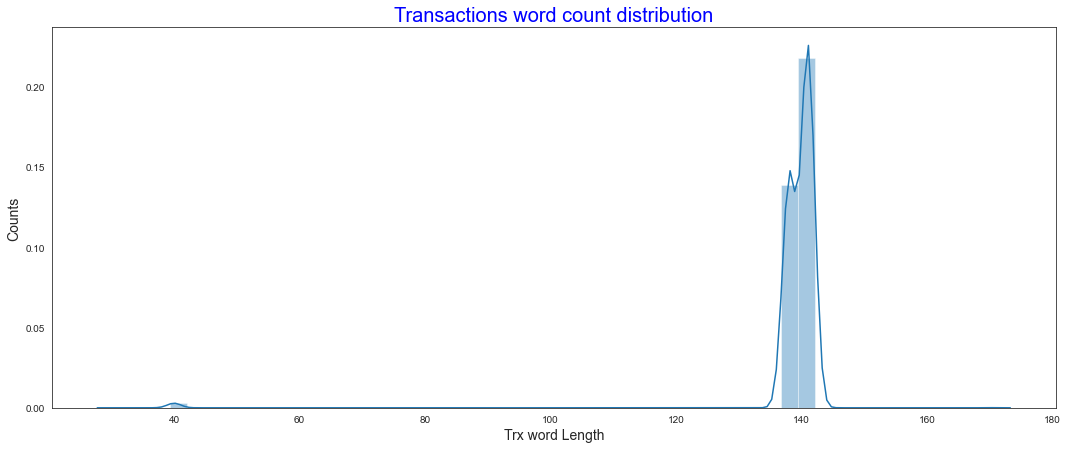

In [9]:
# display the distribution of transactions word counts

sns.set_style('white')
plt.figure(figsize=(18,7))

sns.distplot(a=train_trans['trx_len'])
plt.xlabel('Trx word Length',fontdict = {"fontsize":14})
plt.ylabel('Counts',fontdict = {"fontsize":14})
plt.title('Transactions word count distribution',fontdict = {"fontsize":20,'color':'b'});

## Insights:

Above histogram shows that there are transaction description word count is between 138 to 142, there are few transaction with word count 40 but count is very less.
This shows that we have transaction description same for most of the transactions.

Check Card     92.4650
Debit Card      5.7575
HSA Card        0.9550
Credit Card     0.7800
Card            0.0425
Name: payment_category, dtype: float64


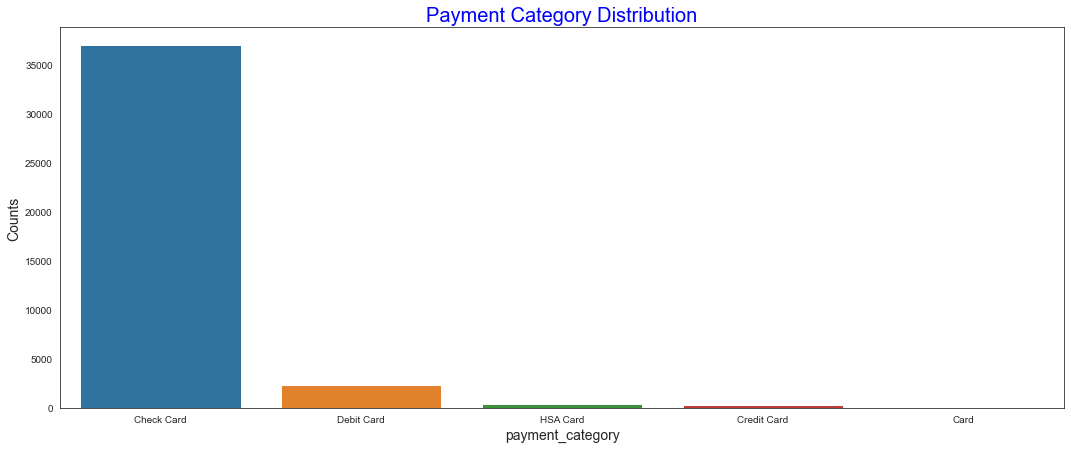

In [10]:
# plot bar chart for payment category distribution

print(train_trans['payment_category'].value_counts(normalize=True)*100)

sns.set_style('white')
plt.figure(figsize=(18,7))

sns.barplot(data=train_trans, x=train_trans['payment_category'].value_counts().index,y=train_trans['payment_category'].value_counts())
plt.xlabel('payment_category',fontdict = {"fontsize":14})
plt.ylabel('Counts',fontdict = {"fontsize":14})
plt.title('Payment Category Distribution',fontdict = {"fontsize":20,'color':'b'});

## Insights:

Above bar chart shows distribution of payment categories and most of the transactions used check card and debit card for purchases.

False    97.1375
True      2.8625
Name: is_international, dtype: float64


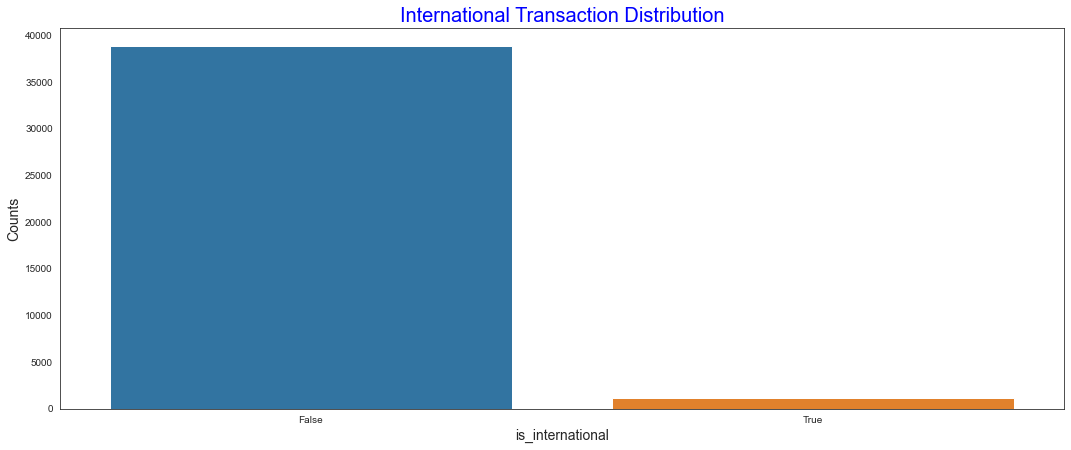

In [11]:
# plot bar chart for is_international

print(train_trans['is_international'].value_counts(normalize=True)*100)

sns.set_style('white')
plt.figure(figsize=(18,7))

sns.barplot(data=train_trans, x=train_trans['is_international'].value_counts().index,y=train_trans['is_international'].value_counts())
plt.xlabel('is_international',fontdict = {"fontsize":14})
plt.ylabel('Counts',fontdict = {"fontsize":14})
plt.title('International Transaction Distribution',fontdict = {"fontsize":20,'color':'b'});

## Insights:

Above bar chart shows that 97% of the transactions are within USA and only 3% transactions are international

### Text Preprocessing:

* Convert Text in vectors -using pre-trained Glove wordembeddings
* Split the data into Train and validation
* Balance Classes of the Training Data 

In [43]:
# transform text in to vectors - training data

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

train_trans['coalesced_brand'] = train_trans['coalesced_brand'].astype('str')

feature_vecs = cv.fit_transform(train_trans['coalesced_brand'])

In [44]:
# transform text in to vectors - testing data

test_trans['coalesced_brand'] = test_trans['coalesced_brand'].astype('str')

test_feature_vecs = cv.transform(test_trans['coalesced_brand'])

In [45]:
feature_vecs.shape

(40000, 25931)

In [46]:
test_feature_vecs.shape

(10000, 25931)

In [16]:
# transform target variable in to number

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

target_codes = le.fit_transform(train_trans['Category'])

In [17]:
# display the encoded values mapping with classes

class_mapping = dict(zip(le.classes_,le.transform(le.classes_)))
print(class_mapping)

{'Communication Services': 0, 'Education': 1, 'Entertainment': 2, 'Finance': 3, 'Health and Community Services': 4, 'Property and Business Services': 5, 'Retail Trade': 6, 'Services to Transport': 7, 'Trade, Professional and Personal Services': 8, 'Travel': 9}


### _Split the data set into train and validation_

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(feature_vecs, target_codes, test_size=0.3, random_state=42)

In [19]:
# display shape of train and validation data sets

f"Training dataset shape: {X_train.shape[0]}"
f"Validation dataset shape: {X_val.shape[0]}"

'Training dataset shape: 28000'

'Validation dataset shape: 12000'

### _Balance the Categories using SMOTE:_

Based on above bar chart we still have imbalnce of categories, in order balance categories, we are going to use SMOTE method
SMOTE method will balance the classes in all categories with same as majority class.

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

In [21]:
# using SMOTE methode balance the classes

features_smote, target_smote = smote.fit_resample(X_train,y_train)

In [22]:
# display shape of X_smote and y_smote & X, y

X_train.shape, y_train.shape
features_smote.shape, target_smote.shape

((28000, 25931), (28000,))

((94950, 25931), (94950,))

In [23]:
# display y_smote distribution and cat column(y)

from collections import Counter

f"Category Classes before balancing: {Counter(y_train)}"
f"Category Classes after balancing: {Counter(target_smote)}"

'Category Classes before balancing: Counter({6: 9495, 2: 7833, 8: 3697, 4: 2901, 7: 1624, 9: 1043, 5: 768, 1: 315, 0: 199, 3: 125})'

'Category Classes after balancing: Counter({8: 9495, 4: 9495, 6: 9495, 2: 9495, 5: 9495, 9: 9495, 3: 9495, 7: 9495, 1: 9495, 0: 9495})'

### Model Selection & Training:

### Naive Bayes Classifier

In [24]:
# import required packages to train model 

from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB()

In [25]:
# train the model using training sata set


model_nb.fit(features_smote,target_smote)

MultinomialNB()

### Evaluation:

In [26]:
# import required packages to evaluate model building

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [27]:
# predict the classes uisng trained model

y_pred = model_nb.predict(X_val)

f"Accuracy of Model: {round(accuracy_score(y_val,y_pred),4)}"

'Accuracy of Model: 0.6638'

{'Communication Services': 0, 'Education': 1, 'Entertainment': 2, 'Finance': 3, 'Health and Community Services': 4, 'Property and Business Services': 5, 'Retail Trade': 6, 'Services to Transport': 7, 'Trade, Professional and Personal Services': 8, 'Travel': 9}
----------------------------------------------------------------------


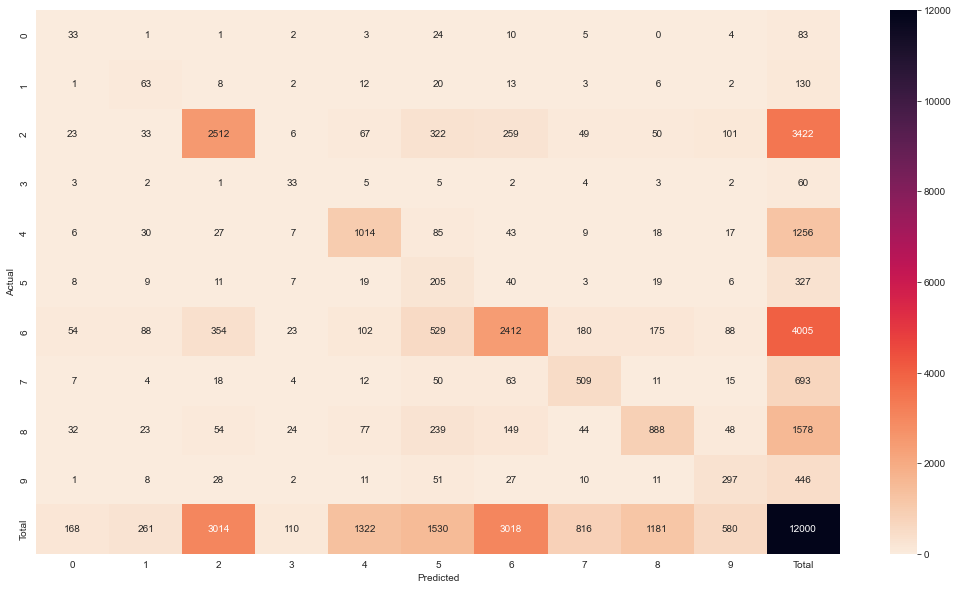

In [28]:
# display confusion matrics result in crosstab

print(class_mapping)
print("-"*70)
cross = pd.crosstab(y_val,y_pred,rownames=['Actual'], colnames=['Predicted'],margins=True,margins_name='Total',dropna=False)

plt.figure(figsize=(18,10))
sns.heatmap(cross,cmap='rocket_r',annot=True,fmt='2g');

In [29]:
# display the classififcation report

print(classification_report(y_val, y_pred, target_names=class_mapping.keys()));

                                           precision    recall  f1-score   support

                   Communication Services       0.20      0.40      0.26        83
                                Education       0.24      0.48      0.32       130
                            Entertainment       0.83      0.73      0.78      3422
                                  Finance       0.30      0.55      0.39        60
            Health and Community Services       0.77      0.81      0.79      1256
           Property and Business Services       0.13      0.63      0.22       327
                             Retail Trade       0.80      0.60      0.69      4005
                    Services to Transport       0.62      0.73      0.67       693
Trade, Professional and Personal Services       0.75      0.56      0.64      1578
                                   Travel       0.51      0.67      0.58       446

                                 accuracy                           0.66     12000
  

### Linear Support Vector Machine

In [30]:
# import required packages for model building

from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()

In [31]:
sgd.fit(features_smote,target_smote)

SGDClassifier()

In [32]:
# predict the classes uisng trained model

y_pred_sgd = sgd.predict(X_val)

# calculate the accuracy of model

f"Accuracy of Model: {round(accuracy_score(y_val,y_pred_sgd),4)}"

'Accuracy of Model: 0.6846'

{'Communication Services': 0, 'Education': 1, 'Entertainment': 2, 'Finance': 3, 'Health and Community Services': 4, 'Property and Business Services': 5, 'Retail Trade': 6, 'Services to Transport': 7, 'Trade, Professional and Personal Services': 8, 'Travel': 9}
----------------------------------------------------------------------


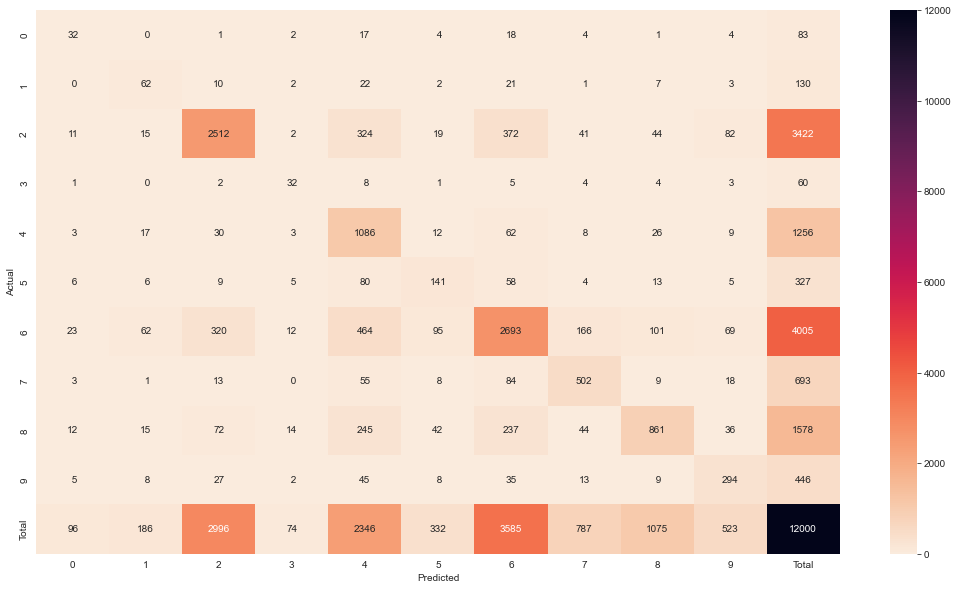

In [33]:
# display confusion matrics result in crosstab

print(class_mapping)
print("-"*70)
cross = pd.crosstab(y_val,y_pred_sgd,rownames=['Actual'], colnames=['Predicted'],margins=True,margins_name='Total',dropna=False)

plt.figure(figsize=(18,10))
sns.heatmap(cross,cmap='rocket_r',annot=True,fmt='2g');

In [34]:
# display the classififcation report

print(classification_report(y_val, y_pred_sgd, target_names=class_mapping.keys()));

                                           precision    recall  f1-score   support

                   Communication Services       0.33      0.39      0.36        83
                                Education       0.33      0.48      0.39       130
                            Entertainment       0.84      0.73      0.78      3422
                                  Finance       0.43      0.53      0.48        60
            Health and Community Services       0.46      0.86      0.60      1256
           Property and Business Services       0.42      0.43      0.43       327
                             Retail Trade       0.75      0.67      0.71      4005
                    Services to Transport       0.64      0.72      0.68       693
Trade, Professional and Personal Services       0.80      0.55      0.65      1578
                                   Travel       0.56      0.66      0.61       446

                                 accuracy                           0.68     12000
  

### XGBOOST Classifier

In [35]:
#  import required packages

from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth = 10, learning_rate=0.0001, objective = 'multi:softmax',num_classes = 10,use_label_encoder=False)

In [36]:
# train the model using training sata set


xgb.fit(features_smote,target_smote)

[21:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0001,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_classes=10, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [37]:
# predict the classes uisng trained model

y_pred_xgb = sgd.predict(X_val)

# calculate the accuracy of model

f"Accuracy of Model: {round(accuracy_score(y_val,y_pred_xgb),4)}"

'Accuracy of Model: 0.6846'

{'Communication Services': 0, 'Education': 1, 'Entertainment': 2, 'Finance': 3, 'Health and Community Services': 4, 'Property and Business Services': 5, 'Retail Trade': 6, 'Services to Transport': 7, 'Trade, Professional and Personal Services': 8, 'Travel': 9}
----------------------------------------------------------------------


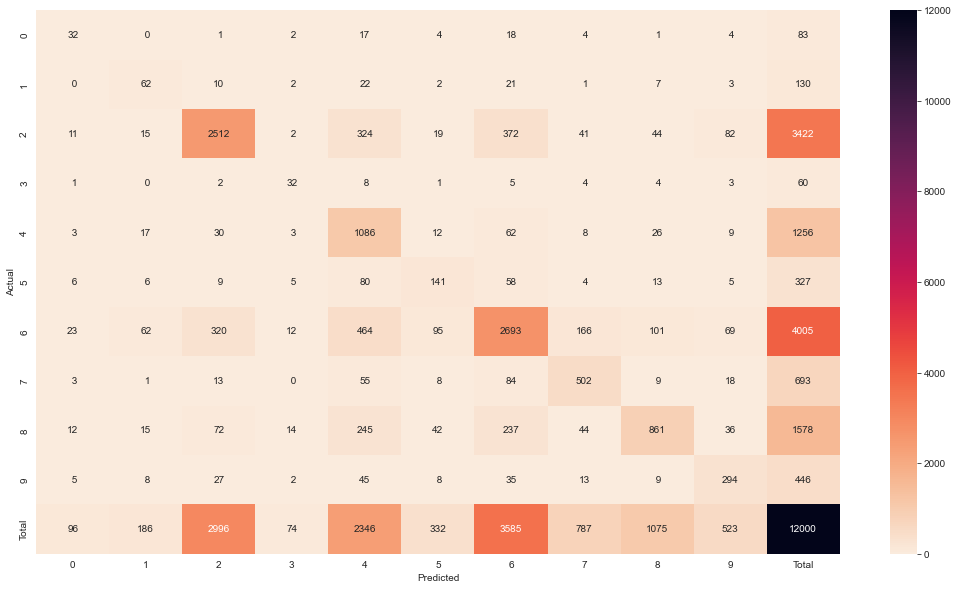

In [38]:
# display confusion matrics result in crosstab

print(class_mapping)
print("-"*70)
cross = pd.crosstab(y_val,y_pred_xgb,rownames=['Actual'], colnames=['Predicted'],margins=True,margins_name='Total',dropna=False)

plt.figure(figsize=(18,10))
sns.heatmap(cross,cmap='rocket_r',annot=True,fmt='2g');

In [39]:
# display the classififcation report

print(classification_report(y_val, y_pred_xgb, target_names=class_mapping.keys()));

                                           precision    recall  f1-score   support

                   Communication Services       0.33      0.39      0.36        83
                                Education       0.33      0.48      0.39       130
                            Entertainment       0.84      0.73      0.78      3422
                                  Finance       0.43      0.53      0.48        60
            Health and Community Services       0.46      0.86      0.60      1256
           Property and Business Services       0.42      0.43      0.43       327
                             Retail Trade       0.75      0.67      0.71      4005
                    Services to Transport       0.64      0.72      0.68       693
Trade, Professional and Personal Services       0.80      0.55      0.65      1578
                                   Travel       0.56      0.66      0.61       446

                                 accuracy                           0.68     12000
  

### Summary of Classifiers Score

In [40]:
classifiers = ['XGBoost','SVM','Naive Bayes']
scores = [0.69,0.69,0.66]

df = pd.DataFrame(scores,index=classifiers, columns=['Acc_Score'])
df

,Acc_Score
XGBoost,0.69
SVM,0.69
Naive Bayes,0.66


### Based on above summary we can baseline XGBoost as baseline model

### Evaluate model with Test Data

In [47]:
# test to see how model predicting categories for test data

test_categories = xgb.predict(test_feature_vecs)

In [59]:
#  assign categories back to labels

test_cat_vals = le.inverse_transform(test_categories)

In [60]:
# test data category result

test_categ = pd.DataFrame(test_cat_vals.reshape(-1,1), columns=['Category'])
test_categ.shape
test_categ.head()

(10000, 1)

,Category
0,Retail Trade
1,Communication Services
2,Retail Trade
3,Retail Trade
4,Communication Services


In [73]:
#  merge category column to test data

result_df = pd.concat([test_trans,test_categ],axis=1)
result_df.shape
result_df.head()

(10000, 14)

,sor,cdf_seq_no,trans_desc,merchant_cat_code,amt,db_cr_cd,payment_reporting_category,payment_category,is_international,default_brand,default_location,qrated_brand,coalesced_brand,Category
0,HH,T20131230990668080055738,CHECK CRD PURCHASE 11/11 PACKAGE EXPRESS ...,NaN,10.35,D,Card,Check Card,False,PACKAGE EXPRESS,LACEY WA,Package Express,Package Express,Retail Trade
1,HH,T201302289918775816,RECUR DEBIT CRD PMT11/11 YP *FRMLY AT&T AD ...,NaN,36.00,D,Card,Debit Card,False,YP *FRMLY AT&T AD,111-111-1111 CA,At And T,At And T,Communication Services
2,HH,T20130726991361190218055,CHECK CRD PURCHASE 11/11 NORMAN G JENSEN IN ...,NaN,27.00,D,Card,Check Card,False,NORMAN G JENSEN IN,111-1111111 MN,Norman G Jensen,Norman G Jensen,Retail Trade
3,HH,T201208319924922772,CHECK CRD PUR RTRN 11/11 TWILIO ...,NaN,20.00,C,Card,Check Card,False,TWILIO,SAN FARANSICO CA,Twilio,Twilio,Retail Trade
4,HH,T20131230990638080027066,CHECK CRD PURCHASE 11/11 AT&T D11K 1111 ...,NaN,325.78,D,Card,Check Card,False,AT&T D11K 1111,FORT WORTH TX,At And T,At And T,Communication Services


In [75]:
# compared categories to transaction description

result_df[['coalesced_brand','Category']]

,coalesced_brand,Category
0,Package Express,Retail Trade
1,At And T,Communication Services
2,Norman G Jensen,Retail Trade
3,Twilio,Retail Trade
4,At And T,Communication Services
...,...,...
9995,Volcano Village Lodge,Retail Trade
9996,La Quinta By Wyndham Springfield Il,Retail Trade
9997,Green Valley Ranch Resort Spa And Casino,Travel
9998,City Of Ontario,Retail Trade


Above dataframe shows the test transactions and predicted categories by the baselines model.

# END